# FACS analysis: transiently transfecting TALEN-clybl codon-specific protein synthesis rate reporter #
* transiently transfect 5.5 ug plasmid into 6 cm plate, passage into 6 well plate after 24 hours and begin starvation after 35 hours, starve for 40 hours (75h post transfection).
* plasmid reporters 1) YFP-WT: Flag-YFPwt-DHFRwt or 2) YFP-CGG:  Flag-YFPcgg-DHFRcgg

In [1]:
%matplotlib inline
from FlowCytometryTools import FCMeasurement
import matplotlib.pyplot as plt
import pandas
import numpy
from IPython.core.display import HTML
from matplotlib.ticker import MaxNLocator, LogLocator, AutoMinorLocator # custom tick locators for plots

/usr/local/lib/python2.7/dist-packages/pandas/computation/expressions.py:21: UserWarning: The installed version of numexpr 2.0.1 is not supported in pandas and will be not be used
The minimum supported version is 2.1

  "version is 2.1\n".format(ver=ver), UserWarning)


In [2]:
sampleids = {1: 'wt_rich_tmp_1',
 2: 'wt_leu_tmp_1',
 3: 'wt_arg_tmp_1',
 7: 'wt_rich_notmp_1',
 8: 'wt_leu_notmp_1',
 9: 'wt_arg_notmp_1',
 4: 'cgg_rich_tmp_1',
 5: 'cgg_leu_tmp_1',
 6: 'cgg_arg_tmp_1',
 10: 'cgg_rich_notmp_1',
 11: 'cgg_leu_notmp_1',
 12: 'cgg_arg_notmp_1',
 13: 'hek293t_untransfected'}

#make sure this is right!

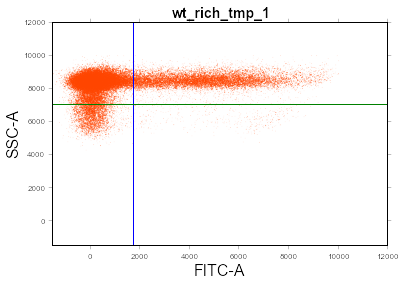

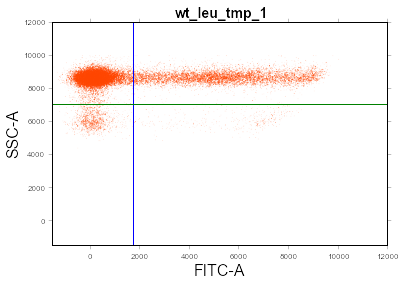

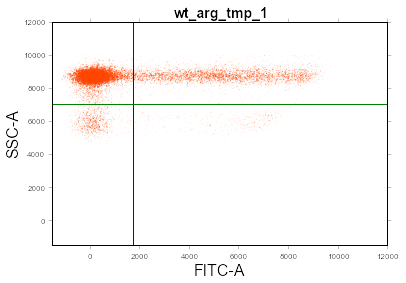

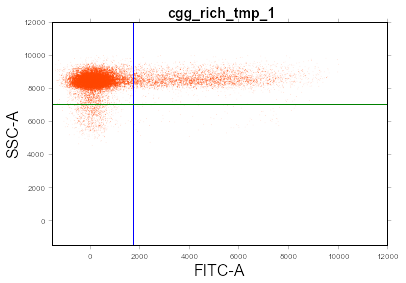

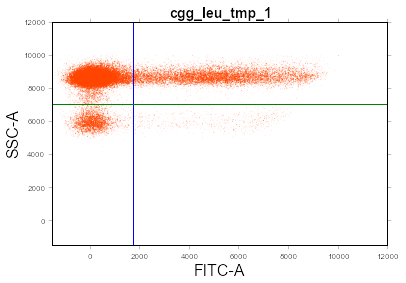

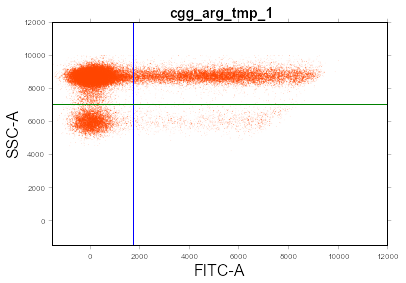

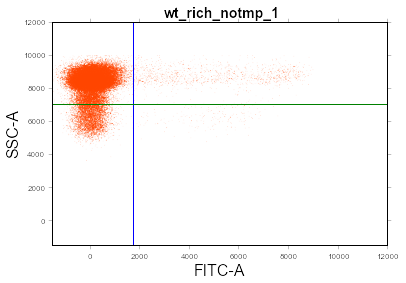

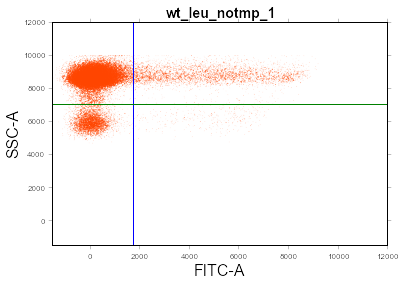

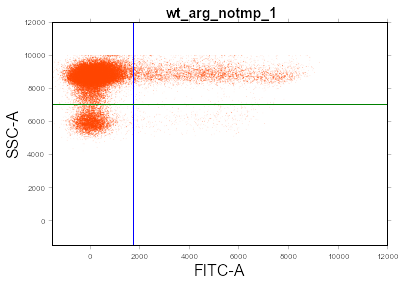

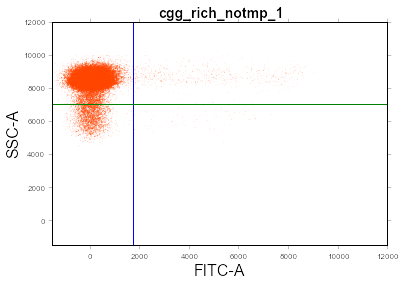

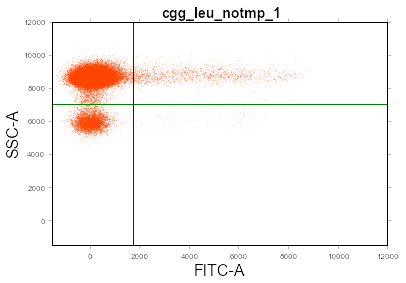

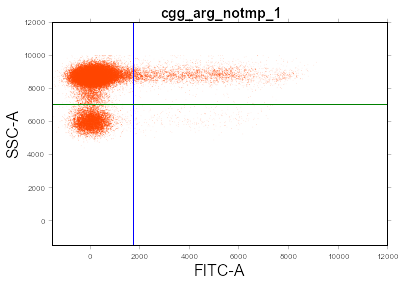

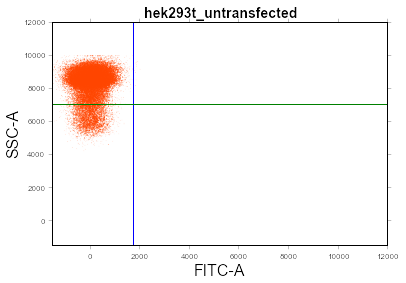

In [11]:
import os, FlowCytometryTools
from FlowCytometryTools import FCMeasurement
from FlowCytometryTools import ThresholdGate
from pylab import *

fcsFiles = !ls fcs_files/*.fcs

for File in fcsFiles:
    ID = int( File.split( '/' )[-1].split( '.' )[0].split('_')[-1] )
    sampleid = sampleids[ID]
    plotsample = FCMeasurement(ID= sampleid, datafile=File)
    #print plotsample.ID
    #print plotsample.channel_names  #names of lasers
    #print plotsample.channels  #useful: gives voltage values for all channels so I can keep this consisent - I changed gain of FITC to 440 in this exp.
    #print type(plotsample.data) #this is a pandas data frame with entries for fsc,ssc, and each laser, and time. 
    #print plotsample.data[['FITC-A', 'PE-A']][:10]  #this prints the 1st 10 entries in each column for FITC/mCherry values
    plotdata = plotsample.data
    #print plotdata['FITC-A'].describe()   #this prints overall statistics about the data for this sample.
    #print plotdata['FITC-A'].median()
    #print plotdata['PE-A'].median()
    #print plotdata.shape[0] #how many events are in the data"tube"
    
    #define gates based on visual analysis of scatter plot
    fitc_gate = ThresholdGate(1750.0, 'FITC-A', region='above')
    ssc_gate = ThresholdGate(7000.0, 'SSC-A', region='above')
    
    tsample = plotsample.transform('hlog', channels=['FITC-A','SSC-A'], b=100)   # b controls the location where the transformation shifts from linear to log. The optimal value for this parameter depends on the range of your data. For smaller ranges, try smaller values of b. So if your population doesn’t show up well, just adjust b.
    axTitle = plotsample.ID
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_ylim(-1500,12000)
    ax.set_xlim(-1500,12000)
    ax.set_title( axTitle, fontsize=14, fontweight='bold')
    #tsample.plot('FITC-A', color='green', bins=100) #plots a 1D histrogram
    tsample.plot(['FITC-A', 'SSC-A'], kind='scatter', gates=[fitc_gate, ssc_gate], color='orangered', s=1, alpha=0.5) #plots a 2d scatter plot. s value adjusts the weight of each point. alpha adjusts the transparency of each point between 1 and 0
    gatedsample = tsample.gate(fitc_gate, ssc_gate)
    
    
    

In [12]:
fcsFiles = !ls fcs_files/*.fcs
processedGatedData = dict()
for File in fcsFiles:
    ID = int( File.split( '/' )[-1].split( '.' )[0].split('_')[-1] )
    sampleid = sampleids[ID]
    
    processedGatedData[ sampleid ] = dict()
    
    plotsample = FCMeasurement(ID= sampleid, datafile=File)
    plotdata = plotsample.data
    
    fitc_gate = ThresholdGate(1750.0, 'FITC-A', region='above')
    ssc_gate = ThresholdGate(7000.0, 'SSC-A', region='above')
    
    tsample = plotsample.transform('hlog', channels=['FITC-A','SSC-A'], b=100)
    gatedsample = tsample.gate(fitc_gate, ssc_gate)
    gatedData = gatedsample.data
    #subset = numpy.logical_and( fcsdata.data['FSC-A'] > fsc_threshold, fcsdata.data['SSC-A'] > ssc_threshold )
    #processedGatedData[ sampleid ]['fsc_median'] = gatedData['FSC-A'].median()
    processedGatedData[ sampleid ]['fitc_mean'] = gatedData['FITC-A'].mean()
    processedGatedData[ sampleid ]['fitc_median'] = gatedData['FITC-A'].median()
    #processeddata[ sampleid ]['fitc_q25'] = fcsdata.data['FITC-A'][subset].quantile(q=0.25)    
    #processeddata[ sampleid ]['fitc_q75'] = fcsdata.data['FITC-A'][subset].quantile(q=0.75)
    #processedGatedData[ sampleid ]['mcherry_median'] = gatedData['PE-A'].median()
    #rocessedGatedData[ sampleid ]['mcherry_mean'] = gatedData['PE-A'].mean()
    #processeddata[ sampleid ]['fsc_q25'] = fcsdata.data['FSC-A'][subset].quantile(q=0.25)    
    #processeddata[ sampleid ]['fsc_q75'] = fcsdata.data['FSC-A'][subset].quantile(q=0.75)        

In [13]:
data = pandas.DataFrame.from_dict( processedGatedData, orient='index' )

In [14]:
data['samplelabel'] = data.index

In [15]:
tmpsamples = map( lambda x: x.find('notmp') == -1, data.index)
dataTmp = data[tmpsamples]
dataNoTmp = data[numpy.logical_not(tmpsamples)]
dataNoTmp.index = map( lambda x: x.replace('_notmp',''), dataNoTmp.index)
dataTmp.index = map( lambda x: x.replace('_tmp',''), dataTmp.index)

In [17]:
dataTmp

,fitc_mean,fitc_median,samplelabel
cgg_arg_1,5227.240679,5246.934570,cgg_arg_tmp_1
cgg_leu_1,5136.306830,5085.307617,cgg_leu_tmp_1
cgg_rich_1,4586.913319,4468.428711,cgg_rich_tmp_1
hek293t_untransfected,1840.967729,1829.735718,hek293t_untransfected
wt_arg_1,5383.735074,5356.857422,wt_arg_tmp_1
wt_leu_1,5409.952623,5369.696045,wt_leu_tmp_1
wt_rich_1,4779.219438,4660.899414,wt_rich_tmp_1


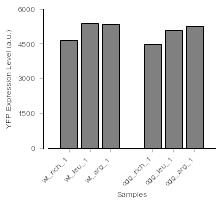

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)

sampleOrder = numpy.array([6,5,4,2,1,0])

xlocations = numpy.array([0,1,2,4,5,6])

ax.bar(xlocations, dataTmp['fitc_median'][sampleOrder], align='center' )
#x.errorbar(xlocations, meanSubtractedData['mean'][sampleOrder], 
            #meanSubtractedData['std'][sampleOrder], linestyle='None', color = 'black' )

spineOffset = {'left': 5, 'bottom': 0}    
[ spine.set_position(('outward',spineOffset[loc])) if loc in ['left','bottom'] 
     else spine.set_color('none') for loc, spine in ax.spines.items() ]         
ax.xaxis.set( ticks_position = 'bottom')
ax.yaxis.set( ticks_position = 'left')
ax.yaxis.set( major_locator = MaxNLocator(5) )

ax.set_xlabel('Samples')
ax.set_xticks(xlocations)
ax.set_xticklabels(dataTmp.index[sampleOrder], rotation=45, ha='right')

ax.set_ylabel( 'YFP Expression Level (a.u.)')

fig.set_size_inches([3,2.5])
fig.savefig('plots/fitcsscgate_yfpmedian_notbackgroundsubtracted.svg')
fig.savefig('plots/fitcsscgate_yfpmedian_notbackgroundsubtracted.png')

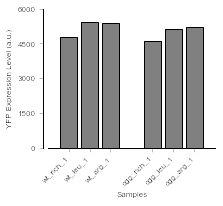

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)

sampleOrder = numpy.array([6,5,4,2,1,0])

xlocations = numpy.array([0,1,2,4,5,6])

ax.bar(xlocations, dataTmp['fitc_mean'][sampleOrder], align='center' )
#x.errorbar(xlocations, meanSubtractedData['mean'][sampleOrder], 
            #meanSubtractedData['std'][sampleOrder], linestyle='None', color = 'black' )

spineOffset = {'left': 5, 'bottom': 0}    
[ spine.set_position(('outward',spineOffset[loc])) if loc in ['left','bottom'] 
     else spine.set_color('none') for loc, spine in ax.spines.items() ]         
ax.xaxis.set( ticks_position = 'bottom')
ax.yaxis.set( ticks_position = 'left')
ax.yaxis.set( major_locator = MaxNLocator(5) )

ax.set_xlabel('Samples')
ax.set_xticks(xlocations)
ax.set_xticklabels(dataTmp.index[sampleOrder], rotation=45, ha='right')

ax.set_ylabel( 'YFP Expression Level (a.u.)')

fig.set_size_inches([3,2.5])
fig.savefig('plots/fitcsscgate_yfpmean_notbackgroundsubtracted.svg')
fig.savefig('plots/fitcsscgate_yfpmean_notbackgroundsubtracted.png')